<a href="https://colab.research.google.com/github/OscarOvanger/GeoDecepticon/blob/main/training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is where the training goes down

 We start of by installing the requirements

In [2]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [3]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 271 (delta 104), reused 39 (delta 35), pack-reused 100 (from 1)
Receiving objects: 100% (271/271), 41.06 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [4]:
import os
os.chdir('/content/GeoDecepticon')

In [5]:
from dataloader import BinaryImageDataset, preprocess_image
from transformer import VisionTransformer
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sample import reconstruct_image_from_patches
import matplotlib.colors as mcolors
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import colors
import os
from torch.optim.lr_scheduler import StepLR

training data shape:  (6000, 64, 64)
test data shape:  (3423, 64, 64)


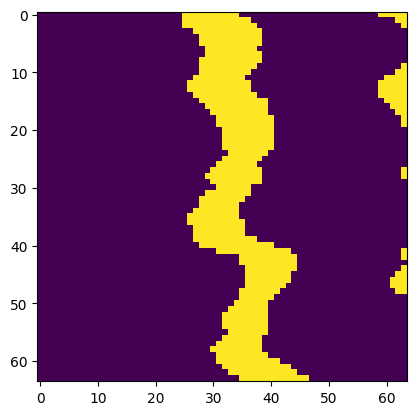

In [6]:
data_1 = np.load("data_array_1.npz")
data_2 = np.load("data_array_2.npz")
data_3 = np.load("data_array_3.npz")

data_array_1 = data_1['data_array']
data_array_2 = data_2['data_array']
data_array_3 = data_3['data_array']

training_data = np.concatenate((data_array_1, data_array_2), axis=0)
test_data = data_array_3
print("training data shape: ", training_data.shape)
print("test data shape: ", test_data.shape)

plt.imshow(training_data[0])
plt.show()

In [7]:
# Create the embedding matrix for all 2x2 binary combinations + 1 mask token
embedding_matrix = torch.zeros((17, 4))  # Shape: (num_tokens, embed_dim)

# Generate all possible 2x2 binary patches
patches = torch.tensor([
    [a, b, c, d]
    for a in range(2)
    for b in range(2)
    for c in range(2)
    for d in range(2)
])  # Shape: (16, 4) for 16 combinations of 2x2 patches

# Assign each patch's values as its embedding
for i, patch in enumerate(patches):
    embedding_matrix[i, :] = patch  # Set the embedding to the patch values

# Set the last row to all 2s for the masked patch
embedding_matrix[-1, :] = 0.5  # Mask token embedding


print("Embedding Matrix:\n", embedding_matrix)

Embedding Matrix:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000]])


In [8]:
# Load the model parameters
# Convert to tensors, should be type Long
training_images = torch.tensor(training_data, dtype=torch.long)
test_images = torch.tensor(test_data, dtype=torch.long)

# Parameters
batch_size = 30
embed_dim = 4
num_heads = 2
feedforward_dim = 128
num_layers = 2
num_tokens = 17  # 16 tokens + 1 mask token
max_patches = 32 * 32
dropout = 0.2
learning_rate = 3e-4
num_epochs = 500
hidden_dim = 32
#initial_mask_rate = 0.2
#final_mask_rate = 0.1

# Dataset and DataLoader
dataset = BinaryImageDataset(training_images)  # Assumes training_images is already loaded
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout, hidden_dim).to(device)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

def prob_log_scheduler(x,max_patches,num_epochs,rand_size):
    value = max_patches*np.log((((np.exp(1)-1)*x)/num_epochs) + 1)
    i = 0
    for val in value:
      rand_comp = np.random.randint(-rand_size,rand_size)
      #print("random value:", rand_comp)
      val = int(val + rand_comp)
      if val > max_patches:
          val = max_patches
      elif val < 1:
          val = 1
      value[i] = val
      i += 1
    return value

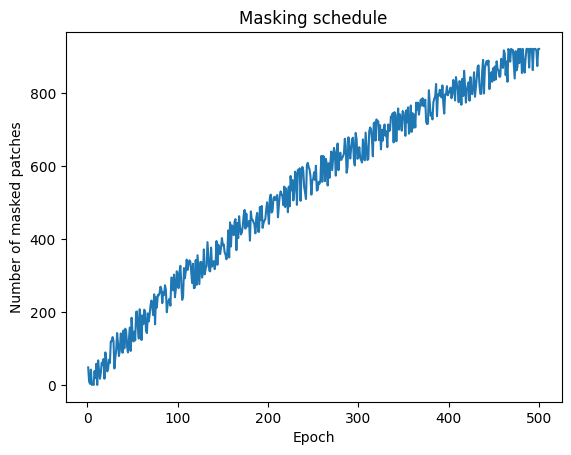

49.0
921.0


In [37]:
x = np.linspace(1,num_epochs,num_epochs)
max_masking = int(max_patches*0.9)
rand_size = 50
y = prob_log_scheduler(x,max_masking,num_epochs,rand_size)
plt.plot(x,y)
plt.title("Masking schedule")
plt.xlabel("Epoch")
plt.ylabel("Number of masked patches")
plt.show()
print(y[0])
print(y[-1])

In [40]:
import wandb
wandb.login()

# Initialize wandb project
wandb.init(
    project="vision-transformer",
    config={
        "batch_size": batch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
        "num_tokens": num_tokens,
        "max_patches": max_patches,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "hidden_dim": hidden_dim,
    },
)


# Directory to save checkpoints
os.makedirs("checkpoints", exist_ok=True)
maskings = y
# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    current_num_mask = int(maskings[epoch])
    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        patch_indices = torch.stack([preprocess_image(img) for img in images]).long() #(btach_size,max_patches)
        masked_patches = patch_indices.clone() #(btach_size,max_patches)

        # Generate random indices for masking
        random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
        # Create the mask tensor
        mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
        mask.scatter_(1, random_indices, True)

        #Mask
        masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token

        # Define weighted CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

        # Move to device
        masked_patches, patch_indices, mask = (
            masked_patches.to(device),
            patch_indices.to(device),
            mask.to(device),
        )

        # Forward pass
        logits = model(masked_patches) # (batch_size,max_patches,num_tokens - 1)
        # Isolate the masked patches
        # Get the indices of True values
        indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
        # Extract logits at masked positions while maintaining row-wise structure
        masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
        masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
        # Reshape to [batch_size, num_masked_patches, num_classes]
        masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
        masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)
        #Compute logits
        loss = criterion(masked_logits.view(-1, num_tokens-1), masked_patch_indices.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log batch metrics
        wandb.log({"batch_loss": loss.item()})

        # Initialize a W&B table outside the loop
        hist_table = wandb.Table(columns=["Masked Patch Index", "True Token", "Predicted Token", "Probability Distribution"])

        # Visualization for the first batch in the epoch
        if batch_idx == 0:
            with torch.no_grad():
                # Initialize predicted_indices with original patch indices
                predicted_indices = patch_indices.cpu()[0].clone()  # (max_patches)

                # Predict only the masked indices
                masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
                predicted_indices[mask[0]] = masked_predictions[0]  # (current_num_masked)

                # Get the probabilities of the masked patches
                masked_probs = torch.softmax(masked_logits, dim=-1).cpu().numpy()  # [batch_size, current_num_masked, num_tokens-1]
                true_indices = masked_patch_indices[0].cpu().numpy()  # [current_num_masked]
                vis_mask = min(current_num_mask, 10)  # Limit visualization to 10 masked patches
                masked_probs = masked_probs[:vis_mask]
                true_indices = true_indices[:vis_mask]

                # Create a W&B Table for histograms of probabilities
                hist_table = wandb.Table(columns=["Masked Patch Index", "True Token", "Predicted Token", "Probability Distribution"])
                for i in range(vis_mask):
                    hist_table.add_data(
                        i,  # Masked patch index
                        int(true_indices[i]),  # True token for the masked patch
                        int(masked_predictions[0][i]),  # Predicted token
                        masked_probs[i].tolist()  # Probability distribution
                    )
                wandb.log({"Masked Patch Probabilities": hist_table})


                # Reconstruct images
                reconstructed_image = reconstruct_image_from_patches(predicted_indices)

                # Prepare masked image for visualization
                visualized_masked_patches = masked_patches.cpu()[0].clone()
                visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
                masked_image = reconstruct_image_from_patches(visualized_masked_patches)

                # Log visualizations to W&B
                wandb.log({
                    "Original Image": wandb.Image(
                        reconstruct_image_from_patches(patch_indices.cpu()[0])
                    ),
                    "Masked Image": wandb.Image(masked_image, caption="Masked Image"),
                    "Reconstructed Image": wandb.Image(
                        reconstructed_image, caption="Reconstructed Image"
                    ),
                })



    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

    # Log epoch metrics
    wandb.log({"epoch_loss": avg_loss, "masked_patches": current_num_mask})

    # Save checkpoint periodically
    if (epoch + 1) % 50 == 0:
        checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved for epoch {epoch+1}")
        wandb.save(checkpoint_path)

# Save the final model
torch.save(model.state_dict(), "vision_transformer_final_balanced.pth")
wandb.save("vision_transformer_final_balanced.pth")
print("Final model saved as 'vision_transformer_final_balanced.pth'.")
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch_loss,▄▄▅▄▃█▄▄▄▄▃▄▃▄▄▃▃▃▃▃▃▄▄▃▃▃▄▃▄▃▃▂▂▄▃▄▃▂▃▁
epoch_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁
masked_patches,▃▁▁▃▁▁▂▃▁▄▂▃▃▄▂▄▂▃▄▆▆▆▃▄▅▅▄▅▆▆▇▅▇▇▅▆▇█▆▇
batch_loss,0.81267
epoch_loss,0.82116
masked_patches,147


/content/GeoDecepticon/dataloader.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32)


Epoch [1/500] completed. Average Loss: 0.8114
Epoch [2/500] completed. Average Loss: 0.8022
Epoch [3/500] completed. Average Loss: 0.8029
Epoch [4/500] completed. Average Loss: 0.7955
Epoch [5/500] completed. Average Loss: 0.8126
Epoch [6/500] completed. Average Loss: 0.7983
Epoch [7/500] completed. Average Loss: 0.8476
Epoch [8/500] completed. Average Loss: 0.7972
Epoch [9/500] completed. Average Loss: 0.7885
Epoch [10/500] completed. Average Loss: 0.7885
Epoch [11/500] completed. Average Loss: 0.8119
Epoch [12/500] completed. Average Loss: 0.7901
Epoch [13/500] completed. Average Loss: 0.7866
Epoch [14/500] completed. Average Loss: 0.7786
Epoch [15/500] completed. Average Loss: 0.7762
Epoch [16/500] completed. Average Loss: 0.7766
Epoch [17/500] completed. Average Loss: 0.7755
Epoch [18/500] completed. Average Loss: 0.7703
Epoch [19/500] completed. Average Loss: 0.7728
Epoch [20/500] completed. Average Loss: 0.7719
Epoch [21/500] completed. Average Loss: 0.7625
Epoch [22/500] complet

batch_loss,▆█▇▅▅▃▃▂▂▁▂▂▂▁▂▂▂▁▁▂▂▂▃▂▂▂▄▂▃▃▃▃▃▃▂▃▃▂▃▂
epoch_loss,██▇▇▇▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▂▃▃▃▃▄▄▄▄▄
masked_patches,▁▁▁▂▂▃▂▃▃▃▃▃▃▄▃▄▄▄▅▄▅▅▅▅▅▆▆▆▇▆▇▇▇▇▇█▇███
batch_loss,0.56779
epoch_loss,0.61414
masked_patches,921


# Sampling

<ipython-input-24-1f0dcb32ac9f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("vision_transformer_sample.pth",map_location=torch.device('cpu'))


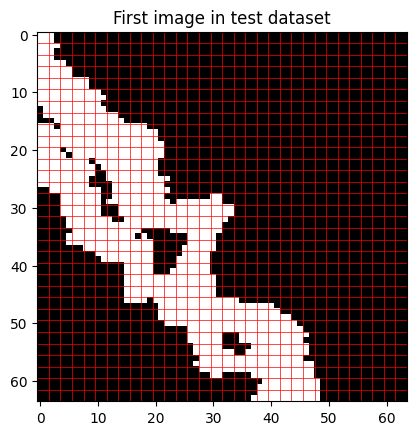

Unique values in masked first image: tensor([-1.,  0.,  1.])


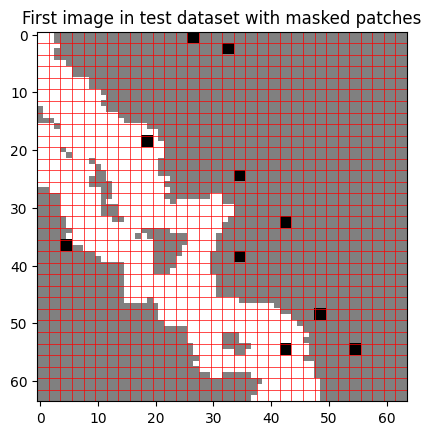

P(Z|obs) = 
0.9995517134666443 *


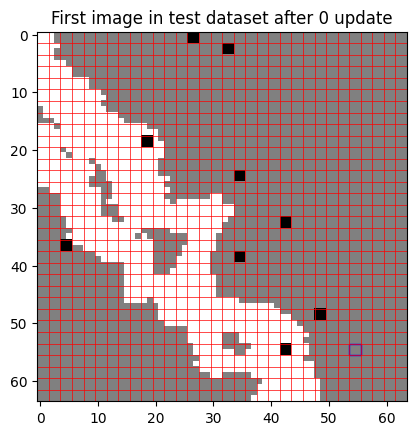

0.9995337724685669 *


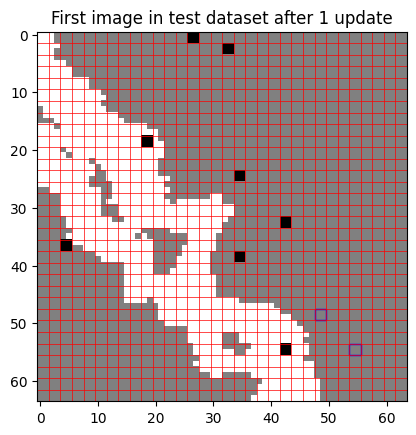

0.9994072914123535 *


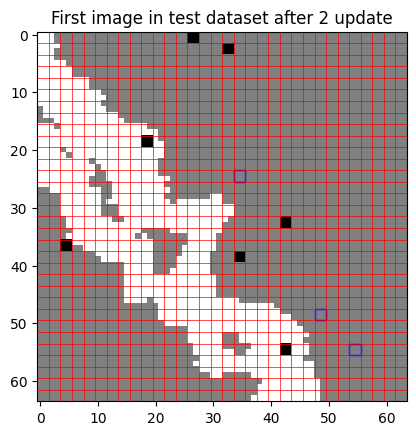

0.9993565678596497 *


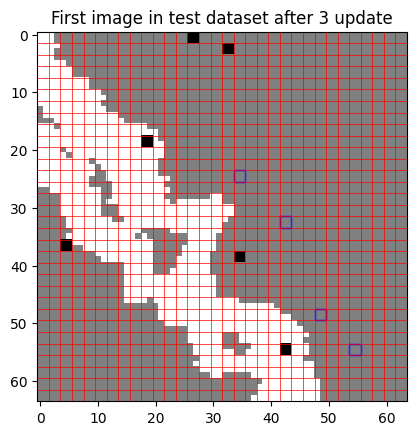

0.9992356300354004 *


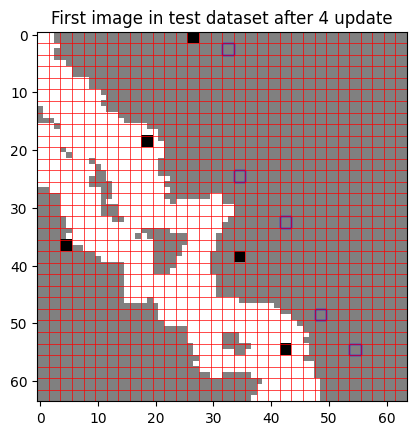

0.9991925358772278 *


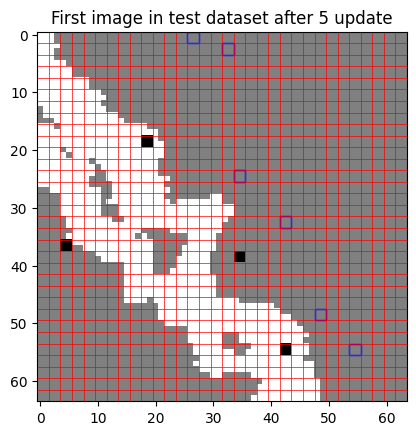

0.9952638149261475 *


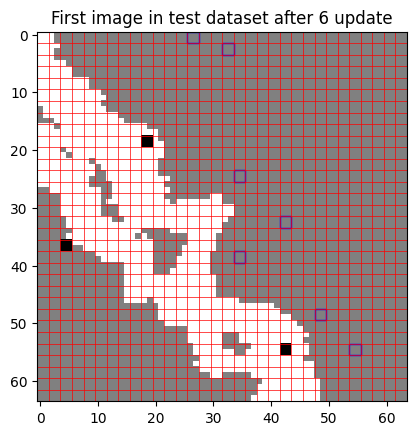

0.8739567399024963 *


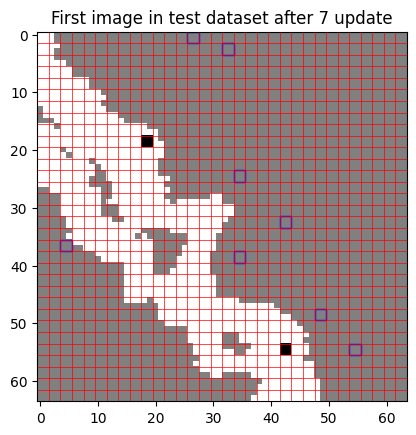

0.7307897210121155 *


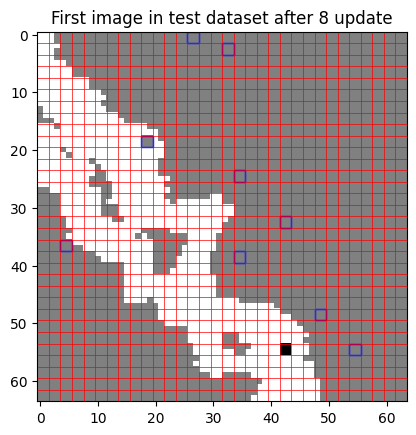

0.5013083219528198 *


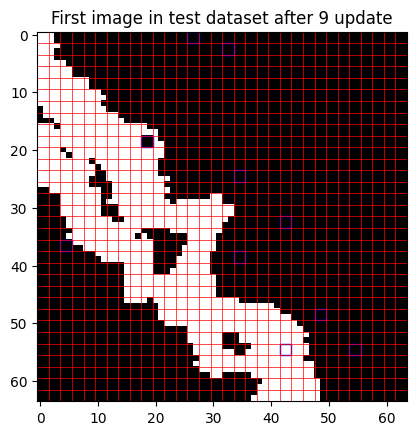

In [24]:
# Load the model
# Load the checkpoint
checkpoint = torch.load("vision_transformer_sample.pth",map_location=torch.device('cpu'))

# Load the model weights from the checkpoint
model.load_state_dict(checkpoint["model_state_dict"])

# Set the model to evaluation mode
model.eval()
# Load the first image from the test data
# Dataset and DataLoader
current_num_mask = 10
batch_size = 1
dataset = BinaryImageDataset(test_images)  # Assumes training_images is already loaded
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
batch_idx, test_images = next(enumerate(dataloader))
first_image = test_images[0]
plt.imshow(first_image,cmap='gray')
for i in range(32):
    plt.axhline(i * 2 - 0.5, color='r', linewidth=0.5)  # Horizontal grid lines
    plt.axvline(i * 2 - 0.5, color='r', linewidth=0.5)  # Vertical grid lines
plt.title("First image in test dataset")
plt.show()

# Preprocess images
patch_indices = torch.stack([preprocess_image(img) for img in test_images]).long() #(batch_size,max_patches)
masked_patches = patch_indices.clone() #(batch_size,max_patches)

# Generate random indices for masking
random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
# Create the mask tensor
mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
mask.scatter_(1, random_indices, True)

#Mask
masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token
masked_patches_vis = masked_patches.clone()
masked_patches_vis[mask] = -1
masked_first_image = reconstruct_image_from_patches(masked_patches_vis[0])

plt.imshow(masked_first_image,cmap='gray')
for i in range(32):
    plt.axhline(i * 2 - 0.5, color='r', linewidth=0.5)  # Horizontal grid lines
    plt.axvline(i * 2 - 0.5, color='r', linewidth=0.5)  # Vertical grid lines
plt.title("First image in test dataset with masked patches")
plt.show()
# Move to device
masked_patches, patch_indices, mask = (
    masked_patches.to(device),
    patch_indices.to(device),
    mask.to(device),
)

"""
This is where the loop starts
"""
updates = []
num_mask = current_num_mask
for i in range(current_num_mask):
  #Get the logits of the masked patches
  logits = model(masked_patches) # (batch_size,max_patches,num_tokens - 1)
  # Isolate the masked patches
  # Get the indices of True values
  indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
  # Extract logits at masked positions while maintaining row-wise structure
  masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
  masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
  # Reshape to [batch_size, num_masked_patches, num_classes]
  masked_logits = masked_logits.view(batch_size, num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
  masked_patch_indices = masked_patch_indices.view(batch_size, num_mask) #(batch_size, current_num_mask)
  masked_probs = torch.softmax(masked_logits, dim=-1) # (batch_size,current_num_mask,num_tokens-1)
  samples = torch.multinomial(masked_probs.view(-1, num_tokens-1), num_samples=1)
  # Get the probabilites of the samples
  prob_samples = torch.gather(masked_probs.view(-1, num_tokens-1), 1, samples.view(-1, 1))

  # Find the argmax
  max_prob = torch.argmax(prob_samples, dim=0)[0]

  mask_idx = torch.nonzero(mask)

  max_prob_idx = mask_idx[max_prob][-1]

  #Update
  masked_patches[0][max_prob_idx] = samples[max_prob][0]

  original_index = torch.unravel_index(max_prob_idx, (32,32))

  #print(f"{prob_samples[max_prob][0]} *")
  masked_patches_vis = masked_patches.clone()
  # update mask

  mask[0][max_prob_idx] = False
  num_mask -= 1
  # Store the masked indices, the value and the probability
  updates.append((max_prob_idx, masked_patches[0][max_prob_idx], prob_samples[max_prob][0]))
  masked_patches_vis[mask] = -1
  # Reconstruct images
  reconstructed_image = reconstruct_image_from_patches(masked_patches_vis[0])
  plt.imshow(reconstructed_image,cmap='gray')
  for j in range(32):
      plt.axhline(j * 2 - 0.5, color='r', linewidth=0.5)  # Horizontal grid lines
      plt.axvline(j * 2 - 0.5, color='r', linewidth=0.5)  # Vertical grid lines
  # Add a blue box for the updated patch
  for j in range(i+1):
    original_index = torch.unravel_index(updates[j][0], (32,32))
    rect = plt.Rectangle((original_index[1]*2-0.5, original_index[0]*2-0.5), 2, 2, color='blue', fill=False)
    plt.gca().add_patch(rect)
  plt.title(f"First image in test dataset after {i} update")
  plt.show()
print("P(Z|obs) = ")
for i in range(current_num_mask):
  if i < current_num_mask - 1:
    print(f"{updates[i][2]} *")
  else:
    print(f"{updates[i][2]}")
print(f"= {math.prod([up[2] for up in updates])}")